# t-Distributed Stochastic Neighbour Estimation (t-SNE)

t-SNE is non-linear dimension reduction method developed by Laurens van der Maaten and Geoffrey Hinton in 2008. It is well-suited for visualization of highly dimensional data.

Unlike methods like the Principal component analysis, t-SNE attempt to keep the local context (neighbours) in the dataset. On the other hand, PCA tries to keep the global structure.

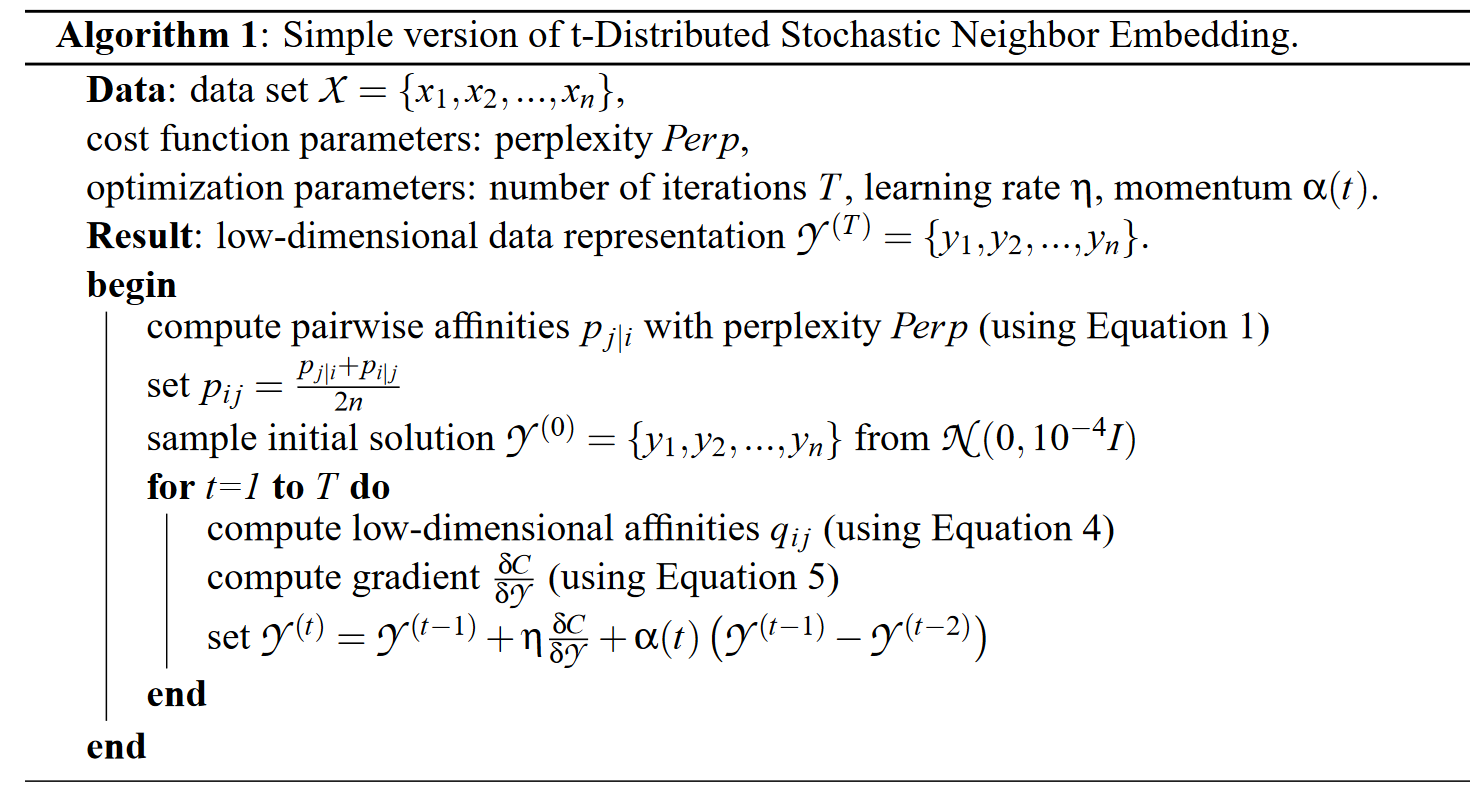

## Imports and dataset creation

In [27]:
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from typing import Callable

### MNIST Dataset

In [28]:
transformer = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(0.5, 0.5)
])

dataset = MNIST(root="data", train=True, download=True, transform=transformer)

In [30]:
data_size = 3000 # len(dataset) or 6000 as in the original paper

train_loader = DataLoader(dataset, batch_size=data_size, shuffle=True)
data_X, y = next(iter(train_loader))


num_of_vars = torch.prod(torch.tensor(data_X.shape[1:]))

X = data_X.view((-1, num_of_vars))


In [31]:
used_principal_components = 30  # Used in the original paper

_, S, V = torch.pca_lowrank(X, q=used_principal_components)

X = X @ V[:, :used_principal_components]



In [32]:
X_numpy = X.numpy()
y_numpy = y.numpy()

### Smaller dataset (for testing purposes) 

In [71]:
n_features = 50

X_numpy, y_numpy = make_classification(n_features=n_features, n_samples=500)


## t-SNE

### High-dimensional space description

In [35]:
def euclid_distance(vector_1: np.ndarray, vector_2: np.ndarray):
    return np.sum((vector_1 - vector_2) ** 2, axis=len(vector_2.shape) - 1)

def get_distance_matrix_memory_unef(points):
    return np.sum((points[None] - points[:, None]) ** 2, axis=2)

def get_distance_matrix(points):
    squared_norms = np.sum(points ** 2, axis=1)
    squared_distances = squared_norms[:, None] + squared_norms[None, :] - 2 * np.dot(points, points.T)
    squared_distances = np.maximum(squared_distances, 0)
    np.fill_diagonal(squared_distances, 0.0)
    return np.sqrt(squared_distances)

def exp_dist_to_all_vectors(distances_from_i, sigma_i):
    return np.exp(-distances_from_i / (2 * sigma_i ** 2))

def conditional_probs_given_i(distances_from_i, sigma_i, eps=1e-15):
    """
    Calculates the conditional probabilities of all points j given i (also for p(i|i))
    """

    exp_distances = exp_dist_to_all_vectors(distances_from_i, sigma_i)
    if distances_from_i.shape[0] == distances_from_i.shape[1]:

        np.fill_diagonal(exp_distances, 0.0)
    return (exp_distances / np.sum(exp_distances, axis=0)) + eps


def shannon_entropy_i(distances_from_i: np.array, sigma_i: np.array):
    probs_j_given_i = conditional_probs_given_i(distances_from_i, sigma_i)
    log_probs = np.log2(probs_j_given_i)
    #log_probs[np.isnan(log_probs) | ~np.isfinite(log_probs)] = 0.0
    return -np.sum(probs_j_given_i * log_probs, axis=0)

def perplexity(distances_from_i, sigma_i):
    return 2 ** shannon_entropy_i(distances_from_i, sigma_i)

### Finding sigmas with binary search

In [36]:
def binary_search(evaluating_function: Callable[[float], float], goal_value: float):
    """
    Binary search for a parameter which produces `goal_value` given the `evaluating_function`.
    """
    left=1e-20
    right=1e6
    tolerance = 1e-4  # NOTE: the code is not optimized enough for lower tolerance
    max_iterations=1000

    for _ in range(max_iterations):
        param_estimate = (left + right) / 2.0

        value_estimate = evaluating_function(param_estimate)

        error = np.abs(goal_value - value_estimate)
        if error <= tolerance:
            return param_estimate
        
        if (value_estimate > goal_value) or not np.isfinite(value_estimate):
            right = param_estimate
        else:
            left = param_estimate
    
    print(f"Iteration limit exceeded, returning parameter {param_estimate}, producing value {value_estimate} (error {error})")
    return param_estimate


def find_sigmas(dists, goal_perplexity):
    num_points = dists.shape[0]
    found_sigmas = np.zeros(num_points)

    dists = dists[~np.eye(dists.shape[0], dtype=bool)].reshape((-1, dists.shape[0] - 1))  # Remove the main diagonal and reshape

    
    for i in range(num_points):
        evaluation_func = lambda sigma: perplexity(dists[[i]].transpose(), np.array([sigma]))
        

        found_sigmas[i] = binary_search(evaluation_func, goal_perplexity)
    return found_sigmas


def compute_affinities(points, perplexity):
    dists = get_distance_matrix(points)
    sigmas = find_sigmas(dists, perplexity)
    affinities = conditional_probs_given_i(dists, sigmas)
    return affinities

def get_symmetrical_probs(conditional_probs):
    return (conditional_probs + conditional_probs.T) / (2 * conditional_probs.shape[0]) 

### Embedding space description

In [37]:
def get_initial_y(num_points, dimension, variance=1e-4):
    return np.random.multivariate_normal(mean=np.zeros(dimension), cov=np.eye(dimension) * variance, size=num_points)


def inverse_dist_to_all_vectors(distances_from_i):
    # Calculate the nominator of q_ij for each vector with respect to i
    return 1 / (1 + distances_from_i)


def get_embedded_probs_from_dists(distances_from_i, eps=1e-15):
    """
    Calculates the conditional probabilities of all points j given i (also for p(i|i))
    """

    inverse_distances = inverse_dist_to_all_vectors(distances_from_i)
    if distances_from_i.shape[0] == distances_from_i.shape[1]:

        np.fill_diagonal(inverse_distances, eps)
    return (inverse_distances / np.sum(inverse_distances, axis=None)) + eps

def get_embedded_affinities(points):
    dists = get_distance_matrix(points)
    return get_embedded_probs_from_dists(dists)


### KL_divergence and its gradient

In [38]:
def KL_divergence(probs_p, probs_q):
    return np.sum(probs_p * np.log(probs_p / probs_q))


def get_difference_matrix(points):
    return points[:, None] - points[None]

def gradient_wrt_y(probs_p, probs_q, points_y):
    prob_diff = probs_p - probs_q
    point_diff = get_difference_matrix(points_y)
    inverse_dists = inverse_dist_to_all_vectors(get_distance_matrix(points_y))

    return 4 * np.sum(prob_diff[..., np.newaxis] * point_diff * inverse_dists[..., np.newaxis], axis=0)

## Training loop

In [39]:
# Cost function parameters
PERPLEXITY = 40

# Optimization parameters
EPOCHS = 20
LEARNING_RATE = 1e-5
MOMENTUM = 0.9

OUTPUT_DIMENSION = 2

In [40]:
def train_tSNE(points, perplexity=40, epochs=1000, learning_rate=None, momentum=None, output_dimension=2, iterations_to_keep=None):
    if momentum is None:
        momentum = [0.5] * 150 + [0.8] * max((epochs - 150), 0)
        momentum = momentum[:epochs]

    if learning_rate is None:
        learning_rate = [1000] * epochs

    if iterations_to_keep is None:
        iterations_to_keep = []

    print("Computing sigmas and conditional probs...")
    cond_probs = compute_affinities(points, perplexity)

    print("Computing joint probs...")
    probs = get_symmetrical_probs(cond_probs)

    points_y = get_initial_y(points.shape[0], output_dimension, variance=1e-15)

    last_y = points_y
    next_to_last_y = points_y
    y_to_return = None

    losses = []
    for iteration_num in range(epochs):
        embedded_probs = get_embedded_affinities(points_y)
        
        loss = KL_divergence(probs, embedded_probs)
        grads = gradient_wrt_y(probs, embedded_probs, points_y)

        
        points_y = last_y \
            + learning_rate[iteration_num] * grads \
            + momentum[iteration_num] * (last_y - next_to_last_y)
        
        """
        points_y = all_y[iteration_num + 1] \
            + learning_rate[iteration_num] * grads
        """
        next_to_last_y, last_y = last_y, points_y

        if iteration_num in iterations_to_keep:
            if y_to_return is None:
                y_to_return = points_y[np.newaxis]
            else:
                y_to_return = np.vstack([y_to_return, points_y[np.newaxis]])


        #all_y = np.vstack([all_y, points_y[np.newaxis]])

        print(f"Iteration {iteration_num+1} complete. Loss: {loss:.6f}")
        losses.append(loss)
    return y_to_return, losses

In [45]:
EPOCHS = 500
PERPLEXITY = 40
learning_rate = [100000] * 3 + [1000] * 20 + [500] * 50
learning_rate = learning_rate + [250] * (EPOCHS - len(learning_rate))

iterations_to_keep = [1] + list(range(100, 1001, 100))

used_points = X_numpy
used_labels = y_numpy

embedded_y, losses = train_tSNE(used_points, epochs=EPOCHS, perplexity=PERPLEXITY, learning_rate=learning_rate, iterations_to_keep=iterations_to_keep)

#plt.scatter(x=embedded_y[:, 0], y=embedded_y[:, 1], c=used_labels)

Computing sigmas and conditional probs...
Computing joint probs...
Iteration 1 complete. Loss: 4.177704
Iteration 2 complete. Loss: 4.177703
Iteration 3 complete. Loss: 4.177690
Iteration 4 complete. Loss: 4.175978
Iteration 5 complete. Loss: 4.164661
Iteration 6 complete. Loss: 4.144561
Iteration 7 complete. Loss: 4.106868
Iteration 8 complete. Loss: 4.041758
Iteration 9 complete. Loss: 3.947944
Iteration 10 complete. Loss: 3.835430
Iteration 11 complete. Loss: 3.718785
Iteration 12 complete. Loss: 3.608555
Iteration 13 complete. Loss: 3.509105
Iteration 14 complete. Loss: 3.420954
Iteration 15 complete. Loss: 3.343124
Iteration 16 complete. Loss: 3.274215
Iteration 17 complete. Loss: 3.212818
Iteration 18 complete. Loss: 3.157765
Iteration 19 complete. Loss: 3.108086
Iteration 20 complete. Loss: 3.062946
Iteration 21 complete. Loss: 3.021732
Iteration 22 complete. Loss: 2.983920
Iteration 23 complete. Loss: 2.949083
Iteration 24 complete. Loss: 2.916815
Iteration 25 complete. Loss: 2

## Training visualization

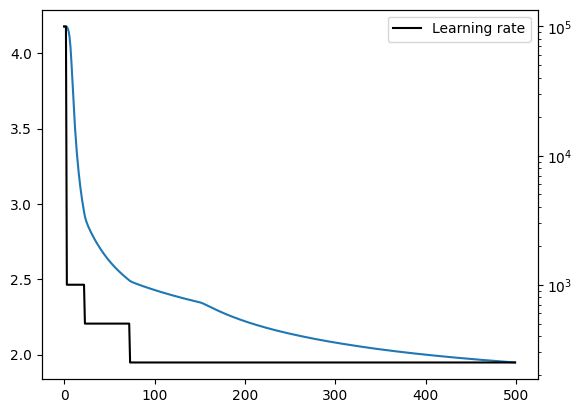

In [46]:
fig, main_ax = plt.subplots()
second_ax = main_ax.twinx()

main_ax.plot(losses)
second_ax.plot(learning_rate, label="Learning rate", color="black")
second_ax.set_yscale("log")
plt.legend()
plt.show()


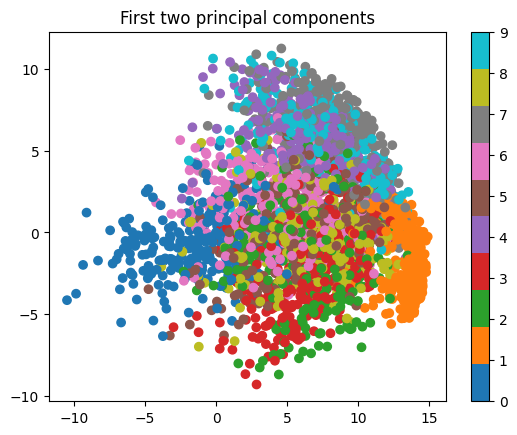

In [43]:
plt.scatter(X_numpy[:, 0], X_numpy[:, 1], c=y_numpy, cmap="tab10")
plt.colorbar()
plt.title("First two principal components");

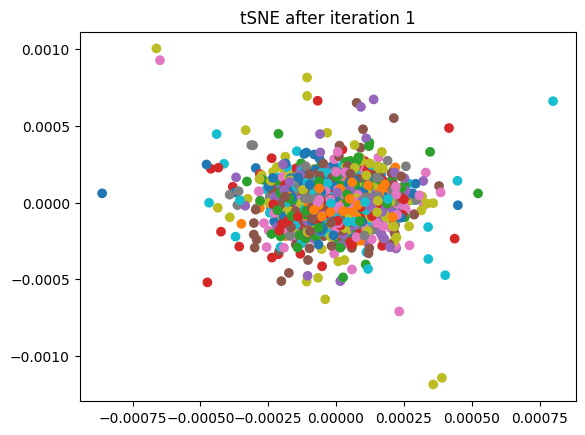

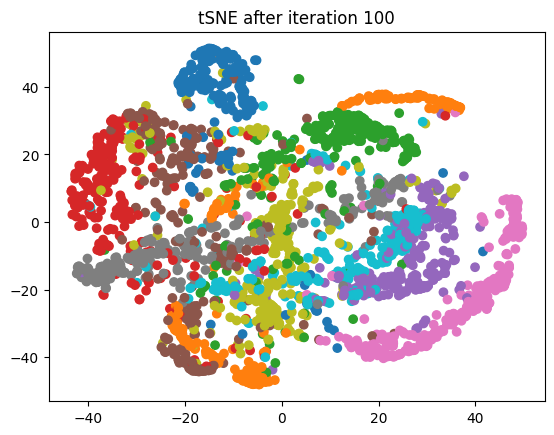

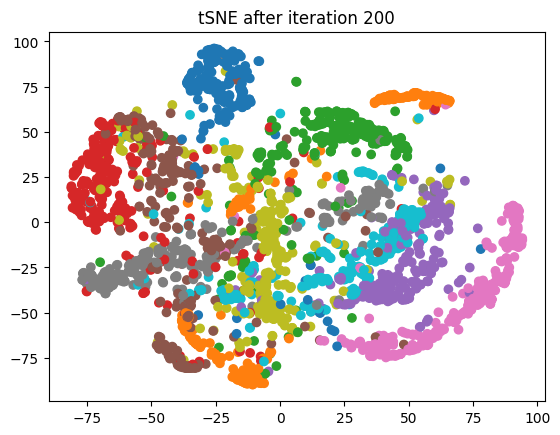

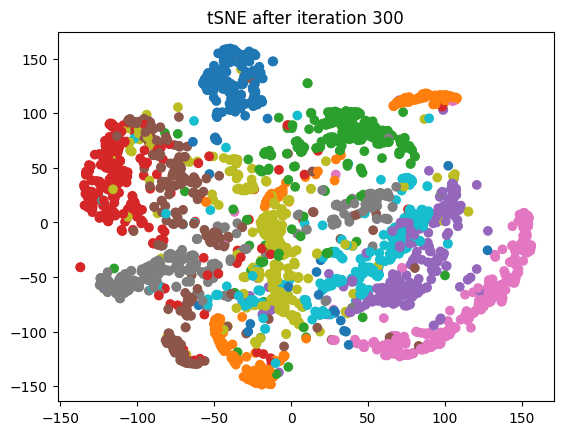

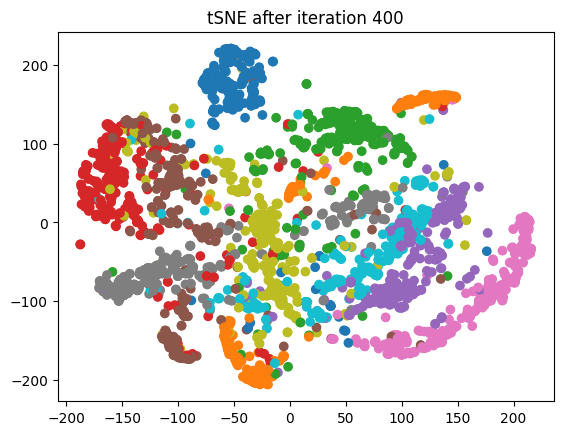

In [47]:
for iteration, generated_points in zip(iterations_to_keep, embedded_y):
    plt.scatter(x=generated_points[:, 0], y=generated_points[:, 1], c=used_labels, cmap="tab10")
    plt.title(f"tSNE after iteration {iteration}")
    plt.show()
